In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [37]:
!cp "drive/My Drive/utils.py" .
import utils
!cp "drive/My Drive/model.py" .
import model

In [38]:
import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM

from model import CSRNet
from image import *
import torch
%matplotlib inline


In [22]:
#this is borrowed from https://github.com/davideverona/deep-crowd-counting_crowdnet
def gaussian_filter_density(gt):
    print gt.shape
    density = np.zeros(gt.shape, dtype=np.float32)
    gt_count = np.count_nonzero(gt)
    if gt_count == 0:
        return density

    pts = np.array(zip(np.nonzero(gt)[1], np.nonzero(gt)[0]))
    leafsize = 2048
    # build kdtree
    tree = scipy.spatial.KDTree(pts.copy(), leafsize=leafsize)
    # query kdtree
    distances, locations = tree.query(pts, k=4)

    print 'generate density...'
    for i, pt in enumerate(pts):
        pt2d = np.zeros(gt.shape, dtype=np.float32)
        pt2d[pt[1],pt[0]] = 1.
        if gt_count > 1:
            sigma = (distances[i][1]+distances[i][2]+distances[i][3])*0.1
        else:
            sigma = np.average(np.array(gt.shape))/2./2. #case: 1 point
        density += scipy.ndimage.filters.gaussian_filter(pt2d, sigma, mode='constant')
    print 'done.'
    return density

In [23]:
#set the root to the Shanghai dataset you download
root = '/content/drive/My Drive/ShanghaiTech_Crowd_Counting_Dataset'

In [24]:
#now generate the ShanghaiA's ground truth
part_A_train = os.path.join(root,'/content/drive/My Drive/part_A_final/train_data','images')
#part_A_train='/content/drive/My Drive/part_A_final/train_data'
part_A_test = os.path.join(root,'/content/drive/My Drive/part_A_final/test_data','images')
#part_A_test='/content/drive/My Drive/part_A_final/test_data'
part_B_train = os.path.join(root,'/content/drive/My Drive/part_B_final/train_data','images')
#part_B_train='/content/drive/My Drive/part_B_final/train_data'
part_B_test = os.path.join(root,'/content/drive/My Drive/part_B_final/test_data','images')
#part_B_test='/content/drive/My Drive/part_B_final/test_data'
path_sets = [part_A_train,part_A_test]

In [36]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [26]:
for img_path in img_paths:
    print img_path
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter_density(k)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

/content/drive/My Drive/part_A_final/train_data/images/IMG_109.jpg
(681, 1024)
generate density...
done.
/content/drive/My Drive/part_A_final/train_data/images/IMG_102.jpg
(768, 1024)
generate density...
done.
/content/drive/My Drive/part_A_final/train_data/images/IMG_101.jpg
(768, 1024)
generate density...
done.
/content/drive/My Drive/part_A_final/train_data/images/IMG_107.jpg
(517, 800)
generate density...
done.
/content/drive/My Drive/part_A_final/train_data/images/IMG_108.jpg
(767, 1024)
generate density...
done.
/content/drive/My Drive/part_A_final/train_data/images/IMG_106.jpg
(675, 1024)
generate density...
done.
/content/drive/My Drive/part_A_final/train_data/images/IMG_110.jpg
(498, 1024)
generate density...
done.
/content/drive/My Drive/part_A_final/train_data/images/IMG_100.jpg
(654, 1024)
generate density...
done.
/content/drive/My Drive/part_A_final/train_data/images/IMG_103.jpg
(400, 400)
generate density...
done.
/content/drive/My Drive/part_A_final/train_data/images/IM

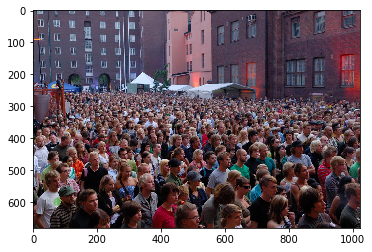

In [27]:
#now see a sample from ShanghaiA
plt.imshow(Image.open(img_paths[0]))

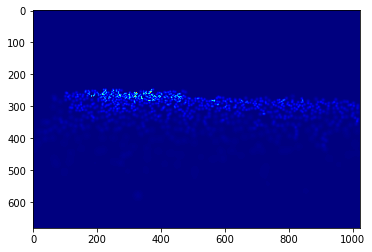

In [28]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)

In [29]:
np.sum(groundtruth)# don't mind this slight variation

859.6924

In [31]:
#now generate the ShanghaiB's ground truth
path_sets = [part_B_train,part_B_test]

In [32]:
img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(img_path)

In [33]:
for img_path in img_paths:
    print img_path
    mat = io.loadmat(img_path.replace('.jpg','.mat').replace('images','ground_truth').replace('IMG_','GT_IMG_'))
    img= plt.imread(img_path)
    k = np.zeros((img.shape[0],img.shape[1]))
    gt = mat["image_info"][0,0][0,0][0]
    for i in range(0,len(gt)):
        if int(gt[i][1])<img.shape[0] and int(gt[i][0])<img.shape[1]:
            k[int(gt[i][1]),int(gt[i][0])]=1
    k = gaussian_filter(k,15)
    with h5py.File(img_path.replace('.jpg','.h5').replace('images','ground_truth'), 'w') as hf:
            hf['density'] = k

/content/drive/My Drive/part_B_final/train_data/images/IMG_1.jpg
/content/drive/My Drive/part_B_final/train_data/images/IMG_10.jpg
/content/drive/My Drive/part_B_final/train_data/images/IMG_100.jpg
/content/drive/My Drive/part_B_final/train_data/images/IMG_105.jpg
/content/drive/My Drive/part_B_final/train_data/images/IMG_103.jpg
/content/drive/My Drive/part_B_final/train_data/images/IMG_104.jpg
/content/drive/My Drive/part_B_final/train_data/images/IMG_101.jpg
/content/drive/My Drive/part_B_final/train_data/images/IMG_102.jpg
/content/drive/My Drive/part_B_final/train_data/images/IMG_108.jpg
/content/drive/My Drive/part_B_final/train_data/images/IMG_106.jpg
/content/drive/My Drive/part_B_final/train_data/images/IMG_107.jpg
/content/drive/My Drive/part_B_final/train_data/images/IMG_109.jpg
/content/drive/My Drive/part_B_final/train_data/images/IMG_111.jpg
/content/drive/My Drive/part_B_final/train_data/images/IMG_110.jpg
/content/drive/My Drive/part_B_final/train_data/images/IMG_11.jpg

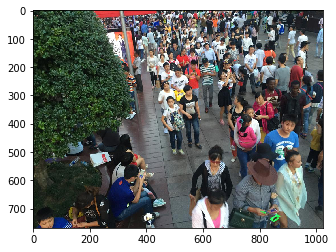

In [34]:
plt.imshow(Image.open(img_paths[0]))

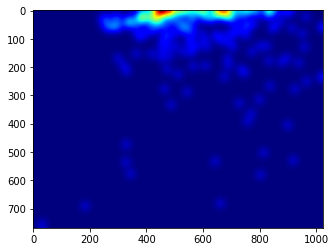

In [35]:
gt_file = h5py.File(img_paths[0].replace('.jpg','.h5').replace('images','ground_truth'),'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)